In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [2]:
results_folder = 'results'
data_types = ['WikiText103','tweets']
algorithms = ['FedAVG', 'LICCHAVI_L1', 'LICCHAVI_L2']

hyperparameters_filename = 'hyperparams.pickle'
metrics_filename = 'metrics.pickle'

In [3]:
def collect():
    results = {}

    for data_type in data_types:
        results[data_type] = {}
        for algorithm in os.listdir(os.path.join(results_folder, data_type)):
            results[data_type][algorithm] = []
            path = os.path.join(results_folder, data_type, algorithm)
            for folder in os.listdir(path):
                hyperparameters_file = os.path.join(path, folder, hyperparameters_filename)
                metrics_file = os.path.join(path, folder, metrics_filename)

                with open(hyperparameters_file, 'rb') as f:
                    hyperparameters = pickle.load(f)
                for params in ['DATA_PARAMETERS', 'MODEL_PARAMETERS', 'TRAINING_PARAMETERS', 'FEDERATED_ARGS']:
                    params = hyperparameters.pop(params)
                    hyperparameters.update(params)

                with open(metrics_file, 'rb') as f:
                    metrics = pickle.load(f)

                # performs the average per epoch
                if 'attack_perplexity' in metrics.keys():
                    att_perp = []
                    model_att_perp = []

                avg_perp, avg_f1, avg_f3 = [], [], []
                model_perp, model_f1, model_f3,  = [],[],[]
                N = hyperparameters['num_training_nodes'] - hyperparameters['num_byzantine']

                for _, values in metrics.items():
                    avg_perp.append(np.mean([values[f'perplexity_{j}'] for j in range(1,N+1)]))
                    avg_f1.append(np.mean([values[f'f1_recall_{j}'] for j in range(1,N+1)]))
                    avg_f3.append(np.mean([values[f'f3_recall_{j}'] for j in range(1,N+1)]))
                    model_perp.append(values['perplexity'])
                    model_f1.append(values['f1_recall'])
                    model_f3.append(values['f3_recall'])
                    if 'attack_perplexity' in metrics.keys():
                        att_perp.append([values[f'attack_perplexity_{j}'] for j in range(1,N+1)])
                        model_att_perp.append(values['attack_perplexity'])
                # selects the best epoch for all metrics
                res = {
                    'min_perpl' : np.min(avg_perp),
                    'max_f1' : np.max(avg_f1),
                    'max_f3' : np.max(avg_f3),
                    'epoch_min_perpl' : np.argmin(avg_perp),
                    'epoch_max_f1' : np.argmax(avg_f1),
                    'epoch_max_f3' : np.argmax(avg_f3),

                    'model_min_perpl' : np.min(model_perp),
                    'model_max_f1' : np.max(model_f1),
                    'model_max_f3' : np.max(model_f3),
                    'model_epoch_min_perpl' : np.argmin(model_perp),
                    'model_epoch_max_f1' : np.argmax(model_f1),
                    'model_epoch_max_f3' : np.argmax(model_f3)
                }



                hyperparameters.update(res)
                results[data_type][algorithm].append(hyperparameters)
    return results

In [4]:
parameters = {
    'FedAVG' : ['node_model_lr', 'C', 'batch_size', 'num_epochs', 'gamma'],
    'LICCHAVI_L1' : ['node_model_lr', 'general_model_lr', 'batch_size','num_epochs'],
    'LICCHAVI_L2' : ['node_model_lr', 'general_model_lr', 'batch_size','num_epochs']
}

In [5]:
def display(data, algorithm, metric, nodes, parameters):
    if nodes:
        l = ['max_f3', 'epoch_max_f3','max_f1','epoch_max_f1','min_perpl','epoch_min_perpl']
    else:
        l = ['model_max_f3', 'model_epoch_max_f3', 'model_max_f1', 'model_epoch_max_f1','model_min_perpl','model_epoch_min_perpl']
    return pd.DataFrame(
        results[data][algorithm]).sort_values(
            metric
        )[parameters+l].set_index(parameters)

# HYPERPARAMETERS

## TWEETS

In [6]:
results = collect()

### FedAVG

In [7]:
display('tweets','FedAVG','max_f3',True,parameters['FedAVG'])

max_f3  epoch_max_f3  \
node_model_lr C batch_size num_epochs gamma                             
0.00100       1 32         1          0.00001  0.331330             0   
                           3          0.00001  0.331330             0   
                           2          0.00001  0.331330             0   
0.00001       1 32         1          0.00001  0.332306             5   
                           2          0.00001  0.332908             5   
                                      0.00001  0.332919             5   
                16         2          0.00001  0.333085             5   
                8          2          0.00001  0.333392             5   
                32         3          0.00001  0.333486             5   
0.00010       1 32         1          0.00001  0.333748             5   
                           3          0.00001  0.334134             4   
                           2          0.00001  0.334224             3   

                                                 max_f1  epoch_max_f1  \
node_model_lr C batch_size num_epochs gamma                             
0.00100       1 32         1          0.00001  0.220690             0   
                           3          0.00001  0.220690             0   
                           2          0.00001  0.220690             0   
0.00001       1 32         1          0.00001  0.221656             5   
                           2          0.00001  0.223022             5   
                                      0.00001  0.222922             5   
                16         2          0.00001  0.222988             5   
                8          2          0.00001  0.223403             5   
                32         3          0.00001  0.223082             5   
0.00010       1 32         1          0.00001  0.223631             3   
                           3          0.00001  0.223841             3   
                           2          0.00001  0.224382             3   

                                                min_perpl  epoch_min_perpl  
node_model_lr C batch_size num_epochs gamma                                 
0.00100       1 32         1          0.00001  159.634948                0  
                           3          0.00001  159.634948                0  
                           2          0.00001  159.634948                0  
0.00001       1 32         1          0.00001  158.567416                5  
                           2          0.00001  157.718701                5  
                                      0.00001  157.744139                5  
                16         2          0.00001  157.467110                4  
                8          2          0.00001  158.013549                2  
                32         3          0.00001  157.226239                5  
0.00010       1 32         1          0.00001  157.845368                2  
                           3          0.00001  159.634948                0  
                           2          0.00001  159.331223                1

In [8]:
display('tweets','FedAVG','model_max_f3',False,parameters['FedAVG'])

model_max_f3  \
node_model_lr C batch_size num_epochs gamma                   
0.00001       1 8          2          0.00001      0.455443   
0.00100       1 32         1          0.00001      0.455550   
                           3          0.00001      0.455550   
0.00010       1 32         3          0.00001      0.455550   
0.00100       1 32         2          0.00001      0.455550   
0.00001       1 16         2          0.00001      0.455966   
0.00010       1 32         2          0.00001      0.456533   
0.00001       1 32         1          0.00001      0.456987   
0.00010       1 32         1          0.00001      0.457063   
0.00001       1 32         2          0.00001      0.457517   
                           3          0.00001      0.457668   
                           2          0.00001      0.457668   

                                               model_epoch_max_f3  \
node_model_lr C batch_size num_epochs gamma                         
0.00001       1 8          2          0.00001                   2   
0.00100       1 32         1          0.00001                   0   
                           3          0.00001                   0   
0.00010       1 32         3          0.00001                   0   
0.00100       1 32         2          0.00001                   0   
0.00001       1 16         2          0.00001                   3   
0.00010       1 32         2          0.00001                   1   
0.00001       1 32         1          0.00001                   5   
0.00010       1 32         1          0.00001                   1   
0.00001       1 32         2          0.00001                   5   
                           3          0.00001                   3   
                           2          0.00001                   5   

                                               model_max_f1  \
node_model_lr C batch_size num_epochs gamma                   
0.00001       1 8          2          0.00001      0.346666   
0.00100       1 32         1          0.00001      0.345994   
                           3          0.00001      0.345994   
0.00010       1 32         3          0.00001      0.346675   
0.00100       1 32         2          0.00001      0.345994   
0.00001       1 16         2          0.00001      0.345843   
0.00010       1 32         2          0.00001      0.346902   
0.00001       1 32         1          0.00001      0.347053   
0.00010       1 32         1          0.00001      0.346599   
0.00001       1 32         2          0.00001      0.347431   
                           3          0.00001      0.347204   
                           2          0.00001      0.347356   

                                               model_epoch_max_f1  \
node_model_lr C batch_size num_epochs gamma                         
0.00001       1 8          2          0.00001                   3   
0.00100       1 32         1          0.00001                   0   
                           3          0.00001                   0   
0.00010       1 32         3          0.00001                   1   
0.00100       1 32         2          0.00001                   0   
0.00001       1 16         2          0.00001                   3   
0.00010       1 32         2          0.00001                   1   
0.00001       1 32         1          0.00001                   4   
0.00010       1 32         1          0.00001                   1   
0.00001       1 32         2          0.00001                   3   
                           3          0.00001                   4   
                           2          0.00001                   3   

                                               model_min_perpl  \
node_model_lr C batch_size num_epochs gamma                      
0.00001       1 8          2          0.00001        57.941335   
0.00100       1 32         1          0.00001        57.600457   
                           3          0.00001        57.600457   
0.00010       1 3

### LICCHAVI_L1

In [9]:
display('tweets','LICCHAVI_L1','max_f3',True,parameters['LICCHAVI_L1'])

max_f3  epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00010          32         1           0.331396             5   
              0.00001          32         1           0.331406             5   
              0.00100          32         1           0.331481             5   
0.00010       0.00010          32         1           0.332054             5   
              0.00100          32         1           0.332114             5   
              0.00001          32         1           0.332256             5   
0.00100       0.00100          32         1           0.334171             5   
              0.00010          32         1           0.336200             5   
              0.00001          32         1           0.336212             5   
              0.00100          32         2           0.337885             5   
                               16         1           0.338052             5   
                               32         3           0.338841             5   
                               8          1           0.339986             5   

                                                        max_f1  epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00010          32         1           0.220769             5   
              0.00001          32         1           0.220704             5   
              0.00100          32         1           0.220804             4   
0.00010       0.00010          32         1           0.221370             5   
              0.00100          32         1           0.221477             5   
              0.00001          32         1           0.221289             5   
0.00100       0.00100          32         1           0.223777             5   
              0.00010          32         1           0.223616             5   
              0.00001          32         1           0.223665             5   
              0.00100          32         2           0.226865             5   
                               16         1           0.227071             5   
                               32         3           0.228271             5   
                               8          1           0.228344             5   

                                                       min_perpl  \
node_model_lr general_model_lr batch_size num_epochs               
0.00001       0.00010          32         1           159.462233   
              0.00001          32         1           159.482477   
              0.00100          32         1           159.475359   
0.00010       0.00010          32         1           158.331611   
              0.00100          32         1           158.239311   
              0.00001          32         1           158.338629   
0.00100       0.00100          32         1           153.173595   
              0.00010          32         1           153.025045   
              0.00001          32         1           153.047489   
              0.00100          32         2           148.719124   
                               16         1           148.485409   
                               32         3           145.419204   
                               8          1           143.090109   

                                                      epoch_min_perpl  
node_model_lr general_model_lr batch_size num_epochs                   
0.00001       0.00010          32         1                         5  
              0.00001          32         1                         5  
              0.00100          32         1                         5  
0.00010       0.00010          32         1                         5  
              0.00100          32         1                         5  
              0.00001          32         1                         5  
0.00100       0.00100          32         1              

In [10]:
display('tweets','LICCHAVI_L1','model_max_f3',False,parameters['LICCHAVI_L1'])

model_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00100       0.00100          16         1               0.454396   
                               8          1               0.454620   
0.00010       0.00010          32         1               0.455550   
0.00100       0.00010          32         1               0.455550   
0.00001       0.00001          32         1               0.455550   
0.00010       0.00001          32         1               0.455550   
0.00100       0.00001          32         1               0.455550   
              0.00100          32         1               0.455625   
0.00001       0.00010          32         1               0.455625   
              0.00100          32         1               0.455701   
0.00100       0.00100          32         3               0.455928   
                                          2               0.455928   
0.00010       0.00100          32         1               0.456155   

                                                      model_epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00100       0.00100          16         1                            1   
                               8          1                            4   
0.00010       0.00010          32         1                            0   
0.00100       0.00010          32         1                            0   
0.00001       0.00001          32         1                            0   
0.00010       0.00001          32         1                            0   
0.00100       0.00001          32         1                            0   
              0.00100          32         1                            2   
0.00001       0.00010          32         1                            2   
              0.00100          32         1                            1   
0.00100       0.00100          32         3                            5   
                                          2                            2   
0.00010       0.00100          32         1                            3   

                                                      model_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00100       0.00100          16         1               0.346142   
                               8          1               0.345694   
0.00010       0.00010          32         1               0.346221   
0.00100       0.00010          32         1               0.346069   
0.00001       0.00001          32         1               0.345994   
0.00010       0.00001          32         1               0.345994   
0.00100       0.00001          32         1               0.345994   
              0.00100          32         1               0.346069   
0.00001       0.00010          32         1               0.346145   
              0.00100          32         1               0.346675   
0.00100       0.00100          32         3               0.347204   
                                          2               0.346372   
0.00010       0.00100          32         1               0.347583   

                                                      model_epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00100       0.00100          16         1                            5   
                               8          1                            4   
0.00010       0.00010          32         1                            4   
0.00100       0.00010          32         1                            1   
0.00001       0.00001          32         1                            0   
0.00010       0.00001          32         1                            0   
0.00100       0.00001          32         1                            0   
              0.00100          32         1                            1   
0.00001       0.00010          32         1        

### LICCHAVI_L2

In [11]:
display('tweets','LICCHAVI_L2','max_f3',True,parameters['LICCHAVI_L2'])

max_f3  epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00100          32         1           0.334227             5   
              0.00010          8          1           0.335684             5   
              0.00100          16         1           0.335787             5   
                               8          1           0.336851             5   
0.00010       0.00100          32         1           0.347708             5   
              0.00001          8          1           0.348893             5   
              0.00010          8          1           0.349470             5   
              0.00100          16         1           0.350170             5   
                               8          1           0.352274             5   
0.00100       0.00100          32         1           0.367082             5   
                               16         1           0.371182             5   
                               32         2           0.372160             5   
              0.00001          8          1           0.372462             5   
              0.00010          8          1           0.372874             5   
              0.00100          8          1           0.374509             5   
                               32         3           0.375518             5   

                                                        max_f1  epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00100          32         1           0.223620             5   
              0.00010          8          1           0.224767             5   
              0.00100          16         1           0.224983             5   
                               8          1           0.225793             5   
0.00010       0.00100          32         1           0.234978             5   
              0.00001          8          1           0.235456             5   
              0.00010          8          1           0.235612             5   
              0.00100          16         1           0.235961             5   
                               8          1           0.237791             5   
0.00100       0.00100          32         1           0.249729             5   
                               16         1           0.253079             5   
                               32         2           0.254299             5   
              0.00001          8          1           0.254443             5   
              0.00010          8          1           0.254346             5   
              0.00100          8          1           0.255842             5   
                               32         3           0.255443             5   

                                                       min_perpl  \
node_model_lr general_model_lr batch_size num_epochs               
0.00001       0.00100          32         1           154.820999   
              0.00010          8          1           152.953249   
              0.00100          16         1           152.930213   
                               8          1           150.810839   
0.00010       0.00100          32         1           138.361795   
              0.00001          8          1           137.158752   
              0.00010          8          1           136.714636   
              0.00100          16         1           135.282388   
                               8          1           132.205482   
0.00100       0.00100          32         1           115.408510   
                               16         1           111.301020   
                               32         2           110.393263   
              0.00001          8          1           111.085096   
              0.00010          8          1           110.775781   
              0.00100          8          1           108.404811   
                  

In [12]:
display('tweets','LICCHAVI_L2','model_max_f3',False,parameters['LICCHAVI_L2'])

model_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00010       0.00001          8          1               0.454022   
0.00100       0.00001          8          1               0.454097   
              0.00010          8          1               0.455218   
0.00001       0.00010          8          1               0.455592   
0.00010       0.00010          8          1               0.455592   
0.00001       0.00100          8          1               0.456863   
                               16         1               0.457237   
                               32         1               0.458425   
0.00010       0.00100          16         1               0.459255   
                               8          1               0.459330   
                               32         1               0.460241   
0.00100       0.00100          8          1               0.460377   
                               16         1               0.460452   
                               32         3               0.461829   
                                          1               0.461905   
                                          2               0.462208   

                                                      model_epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00010       0.00001          8          1                            0   
0.00100       0.00001          8          1                            5   
              0.00010          8          1                            5   
0.00001       0.00010          8          1                            5   
0.00010       0.00010          8          1                            5   
0.00001       0.00100          8          1                            1   
                               16         1                            1   
                               32         1                            1   
0.00010       0.00100          16         1                            5   
                               8          1                            5   
                               32         1                            4   
0.00100       0.00100          8          1                            5   
                               16         1                            4   
                               32         3                            5   
                                          1                            5   
                                          2                            5   

                                                      model_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00010       0.00001          8          1               0.344946   
0.00100       0.00001          8          1               0.344946   
              0.00010          8          1               0.345769   
0.00001       0.00010          8          1               0.346068   
0.00010       0.00010          8          1               0.345918   
0.00001       0.00100          8          1               0.347339   
                               16         1               0.347039   
                               32         1               0.348188   
0.00010       0.00100          16         1               0.350254   
                               8          1               0.350404   
                               32         1               0.351441   
0.00100       0.00100          8          1               0.350329   
                               16         1               0.349581   
                               32         3               0.350533   
                                          1               0.350987   
                                          2               0.350836   

                                                      model_epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00010    

# wiki

In [13]:
results = collect()

## FedAVG

In [14]:
display('WikiText103','FedAVG','max_f3',True,parameters['FedAVG'])

max_f3  epoch_max_f3  \
node_model_lr C batch_size num_epochs gamma                             
0.00100       1 16         1          0.00001  0.373530             1   
0.00010       1 8          3          0.00001  0.373744             2   
0.00001       1 16         1          0.00001  0.373764             5   
0.00010       1 16         1          0.00001  0.374135             5   
                8          2          0.00001  0.374359             3   
                           1          0.00001  0.375153             5   

                                                 max_f1  epoch_max_f1  \
node_model_lr C batch_size num_epochs gamma                             
0.00100       1 16         1          0.00001  0.242891             1   
0.00010       1 8          3          0.00001  0.242504             4   
0.00001       1 16         1          0.00001  0.241259             5   
0.00010       1 16         1          0.00001  0.243385             3   
                8          2          0.00001  0.243888             4   
                           1          0.00001  0.242832             2   

                                                min_perpl  epoch_min_perpl  
node_model_lr C batch_size num_epochs gamma                                 
0.00100       1 16         1          0.00001  114.336202                1  
0.00010       1 8          3          0.00001  114.317072                1  
0.00001       1 16         1          0.00001  114.451293                5  
0.00010       1 16         1          0.00001  114.309637                4  
                8          2          0.00001  114.323496                1  
                           1          0.00001  114.379785                1

In [15]:
display('WikiText103','FedAVG','max_f3',False,parameters['FedAVG'])

model_max_f3  \
node_model_lr C batch_size num_epochs gamma                   
0.00100       1 16         1          0.00001      0.366207   
0.00010       1 8          3          0.00001      0.366298   
0.00001       1 16         1          0.00001      0.366230   
0.00010       1 16         1          0.00001      0.366268   
                8          2          0.00001      0.366207   
                           1          0.00001      0.366207   

                                               model_epoch_max_f3  \
node_model_lr C batch_size num_epochs gamma                         
0.00100       1 16         1          0.00001                   0   
0.00010       1 8          3          0.00001                   1   
0.00001       1 16         1          0.00001                   1   
0.00010       1 16         1          0.00001                   1   
                8          2          0.00001                   0   
                           1          0.00001                   0   

                                               model_max_f1  \
node_model_lr C batch_size num_epochs gamma                   
0.00100       1 16         1          0.00001      0.237349   
0.00010       1 8          3          0.00001      0.237349   
0.00001       1 16         1          0.00001      0.237492   
0.00010       1 16         1          0.00001      0.237612   
                8          2          0.00001      0.237349   
                           1          0.00001      0.237492   

                                               model_epoch_max_f1  \
node_model_lr C batch_size num_epochs gamma                         
0.00100       1 16         1          0.00001                   0   
0.00010       1 8          3          0.00001                   0   
0.00001       1 16         1          0.00001                   4   
0.00010       1 16         1          0.00001                   5   
                8          2          0.00001                   0   
                           1          0.00001                   1   

                                               model_min_perpl  \
node_model_lr C batch_size num_epochs gamma                      
0.00100       1 16         1          0.00001       108.457805   
0.00010       1 8          3          0.00001       108.457805   
0.00001       1 16         1          0.00001       108.457113   
0.00010       1 16         1          0.00001       108.450155   
                8          2          0.00001       108.457805   
                           1          0.00001       108.450130   

                                               model_epoch_min_perpl  
node_model_lr C batch_size num_epochs gamma                           
0.00100       1 16         1          0.00001                      0  
0.00010       1 8          3          0.00001                      0  
0.00001       1 16         1          0.00001                      1  
0.00010       1 16         1          0.00001                      1  
                8          2          0.00001                      0  
                           1          0.00001                      1

## LICCHAVI_L1

In [16]:
display('WikiText103','LICCHAVI_L1','max_f3',True,parameters['LICCHAVI_L1'])

max_f3  epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00001          16         1           0.373203             5   
              0.00010          16         1           0.373291             5   
              0.00100          16         1           0.373419             4   
0.00010       0.00001          16         1           0.374240             1   
              0.00010          16         1           0.374421             5   
              0.00100          16         1           0.374602             5   
0.00100       0.00001          16         3           0.376376             1   
                               8          1           0.376597             4   
                               16         2           0.377088             1   
              0.00100          16         1           0.377093             1   
              0.00010          16         1           0.377229             3   
              0.00001          16         1           0.377777             1   

                                                        max_f1  epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00001          16         1           0.241026             5   
              0.00010          16         1           0.241170             3   
              0.00100          16         1           0.241266             3   
0.00010       0.00001          16         1           0.241674             5   
              0.00010          16         1           0.242825             5   
              0.00100          16         1           0.242545             4   
0.00100       0.00001          16         3           0.247141             1   
                               8          1           0.245806             5   
                               16         2           0.246322             1   
              0.00100          16         1           0.247618             5   
              0.00010          16         1           0.245674             3   
              0.00001          16         1           0.246481             3   

                                                       min_perpl  \
node_model_lr general_model_lr batch_size num_epochs               
0.00001       0.00001          16         1           114.421899   
              0.00010          16         1           114.406424   
              0.00100          16         1           114.374881   
0.00010       0.00001          16         1           113.983577   
              0.00010          16         1           113.830110   
              0.00100          16         1           113.700142   
0.00100       0.00001          16         3           108.879460   
                               8          1           109.650282   
                               16         2           109.739778   
              0.00100          16         1           110.533703   
              0.00010          16         1           110.502265   
              0.00001          16         1           110.468516   

                                                      epoch_min_perpl  
node_model_lr general_model_lr batch_size num_epochs                   
0.00001       0.00001          16         1                         5  
              0.00010          16         1                         4  
              0.00100          16         1                         5  
0.00010       0.00001          16         1                         5  
              0.00010          16         1                         5  
              0.00100          16         1                         4  
0.00100       0.00001          16         3                         5  
                               8          1                         5  
                               16         2                         5  
              0.00100          16         1                         1

In [17]:
display('WikiText103','LICCHAVI_L1','max_f3',False,parameters['LICCHAVI_L1'])

model_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00001       0.00001          16         1               0.366260   
              0.00010          16         1               0.366358   
              0.00100          16         1               0.366658   
0.00010       0.00001          16         1               0.366260   
              0.00010          16         1               0.366410   
              0.00100          16         1               0.366651   
0.00100       0.00001          16         3               0.366222   
                               8          1               0.366238   
                               16         2               0.366238   
              0.00100          16         1               0.366207   
              0.00010          16         1               0.366365   
              0.00001          16         1               0.366245   

                                                      model_epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00001       0.00001          16         1                            5   
              0.00010          16         1                            1   
              0.00100          16         1                            1   
0.00010       0.00001          16         1                            4   
              0.00010          16         1                            3   
              0.00100          16         1                            1   
0.00100       0.00001          16         3                            1   
                               8          1                            5   
                               16         2                            5   
              0.00100          16         1                            0   
              0.00010          16         1                            1   
              0.00001          16         1                            3   

                                                      model_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00001       0.00001          16         1               0.237432   
              0.00010          16         1               0.237514   
              0.00100          16         1               0.237965   
0.00010       0.00001          16         1               0.237424   
              0.00010          16         1               0.237800   
              0.00100          16         1               0.238048   
0.00100       0.00001          16         3               0.237409   
                               8          1               0.237432   
                               16         2               0.237424   
              0.00100          16         1               0.237943   
              0.00010          16         1               0.237672   
              0.00001          16         1               0.237447   

                                                      model_epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00001       0.00001          16         1                            4   
              0.00010          16         1                            1   
              0.00100          16         1                            1   
0.00010       0.00001          16         1                            4   
              0.00010          16         1                            5   
              0.00100          16         1                            1   
0.00100       0.00001          16         3                            5   
                               8          1                            4   
                               16         2                            4   
              0.00100          16         1                            2   
              0.00010          16         1                            4   
              0.00001          16      

## LICCHAVI_L2

In [18]:
display('WikiText103','LICCHAVI_L2','max_f3',True,parameters['LICCHAVI_L2'])

max_f3  epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00100          16         1           0.374227             4   
              0.00010          16         1           0.374250             5   
              0.00001          16         1           0.374266             5   
0.00010       0.00001          16         1           0.379061             5   
              0.00010          16         1           0.379249             5   
              0.00100          16         1           0.379458             5   
                               8          1           0.381921             5   
                               16         2           0.382973             5   
                                          3           0.385033             5   
0.00100       0.00100          16         1           0.387386             5   
              0.00001          16         1           0.388777             4   
              0.00010          16         1           0.389461             5   

                                                        max_f1  epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                           
0.00001       0.00100          16         1           0.241266             2   
              0.00010          16         1           0.241174             5   
              0.00001          16         1           0.241257             2   
0.00010       0.00001          16         1           0.247404             5   
              0.00010          16         1           0.247327             4   
              0.00100          16         1           0.247198             5   
                               8          1           0.249734             5   
                               16         2           0.250803             5   
                                          3           0.252433             5   
0.00100       0.00100          16         1           0.253914             4   
              0.00001          16         1           0.252607             4   
              0.00010          16         1           0.252319             4   

                                                       min_perpl  \
node_model_lr general_model_lr batch_size num_epochs               
0.00001       0.00100          16         1           113.285927   
              0.00010          16         1           113.346709   
              0.00001          16         1           113.400321   
0.00010       0.00001          16         1           106.331638   
              0.00010          16         1           106.230043   
              0.00100          16         1           105.878764   
                               8          1           101.963553   
                               16         2           100.872607   
                                          3            97.551380   
0.00100       0.00100          16         1            90.349113   
              0.00001          16         1            91.073647   
              0.00010          16         1            90.912399   

                                                      epoch_min_perpl  
node_model_lr general_model_lr batch_size num_epochs                   
0.00001       0.00100          16         1                         5  
              0.00010          16         1                         5  
              0.00001          16         1                         5  
0.00010       0.00001          16         1                         5  
              0.00010          16         1                         5  
              0.00100          16         1                         5  
                               8          1                         5  
                               16         2                         5  
                                          3                         5  
0.00100       0.00100          16         1                         5

In [19]:
display('WikiText103','LICCHAVI_L2','max_f3',False,parameters['LICCHAVI_L2'])

model_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00001       0.00100          16         1               0.366561   
              0.00010          16         1               0.366260   
              0.00001          16         1               0.366253   
0.00010       0.00001          16         1               0.366290   
              0.00010          16         1               0.366358   
              0.00100          16         1               0.366636   
                               8          1               0.366253   
                               16         2               0.366463   
                                          3               0.366471   
0.00100       0.00100          16         1               0.366621   
              0.00001          16         1               0.366275   
              0.00010          16         1               0.366425   

                                                      model_epoch_max_f3  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00001       0.00100          16         1                            1   
              0.00010          16         1                            2   
              0.00001          16         1                            3   
0.00010       0.00001          16         1                            4   
              0.00010          16         1                            3   
              0.00100          16         1                            1   
                               8          1                            2   
                               16         2                            1   
                                          3                            1   
0.00100       0.00100          16         1                            2   
              0.00001          16         1                            5   
              0.00010          16         1                            4   

                                                      model_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                 
0.00001       0.00100          16         1               0.238025   
              0.00010          16         1               0.237635   
              0.00001          16         1               0.237462   
0.00010       0.00001          16         1               0.237514   
              0.00010          16         1               0.237838   
              0.00100          16         1               0.238033   
                               8          1               0.238056   
                               16         2               0.238010   
                                          3               0.238131   
0.00100       0.00100          16         1               0.238123   
              0.00001          16         1               0.237454   
              0.00010          16         1               0.237853   

                                                      model_epoch_max_f1  \
node_model_lr general_model_lr batch_size num_epochs                       
0.00001       0.00100          16         1                            1   
              0.00010          16         1                            1   
              0.00001          16         1                            5   
0.00010       0.00001          16         1                            5   
              0.00010          16         1                            5   
              0.00100          16         1                            1   
                               8          1                            1   
                               16         2                            2   
                                          3                            1   
0.00100       0.00100          16         1                            1   
              0.00001          16         1                            3   
              0.00010          16      

# ATTACKS

## Normal Data Poisoning

{ 

   data : {
   
       alg : {
       
           attack : {
               
               num_nodes : {
                   
                   f : {
                       
                       list1 : []
                       
                       list2 : []
                   
                   }
                   
               }
               
           }
       }
   }
}

In [20]:
results_folder = 'attacks_results'

all_metrics = {}

agg = {}
for data in data_types:
    agg[data] = {}
    for algorithm in algorithms:
        agg[data][algorithm] = {}
        path = os.path.join(results_folder, data, algorithm)
        for file in os.listdir(path):
            hyperparams_file = os.path.join(path, file, hyperparameters_filename)
            metrics_file = os.path.join(path, file, metrics_filename)
            
            with open(hyperparams_file, 'rb') as f:
                hyperparams = pickle.load(f)

            with open(metrics_file, 'rb') as f:
                metrics = pickle.load(f)
              
            byz_type = hyperparams['FEDERATED_ARGS']['byzantine_type']
            K = hyperparams['FEDERATED_ARGS']['num_training_nodes']
            f = hyperparams['FEDERATED_ARGS']['num_byzantine']
            f = f/K

            if byz_type != 'null':
                layers = None
                if 'max' in metrics[0].keys():
                    layers = metrics.pop('layers')
                    # for every round, the first is the general reg, the last the total gradient and
                    # the intermediat the nodes gradients. So x[-1] only takes the general gradient
                    max_ = [x[-1] for x in [metrics[i].pop('max') for i in range(0, 21)][1:]]
                    avg = [x[-1] for x in [metrics[i].pop('avg') for i in range(0, 21)][1:]]
                    L1 = [x[-1] for x in [metrics[i].pop('L1') for i in range(0, 21)][1:]]
                
                nodes_att_perpl = list(pd.DataFrame(metrics).T.filter(regex = r'attack_perplexity_').T.mean())
                nodes_f3_recall = list(pd.DataFrame(metrics).T.filter(regex = r'f3_recall_').T.mean())
                
                model_att_perpl = list(pd.DataFrame(metrics).T['attack_perplexity'])
                model_f3_recall = list(pd.DataFrame(metrics).T['f3_recall'])
                
                if byz_type not in agg[data][algorithm].keys():
                    agg[data][algorithm][byz_type] = {}
                
                if K not in agg[data][algorithm][byz_type].keys():
                    agg[data][algorithm][byz_type][K] = {}
                
                agg[data][algorithm][byz_type][K][f] = {
                    'nodes_att_perpl' : nodes_att_perpl,
                    'nodes_f3_recall' : nodes_f3_recall,
                    'model_att_perpl' : model_att_perpl,
                    'model_f3_recall' : model_f3_recall,
                    'params' : hyperparams
                }
                
                
                if layers is not None:
                    agg[data][algorithm][byz_type][K][f].update({
                        'layers' : layers,
                        'max' : max_,
                        'avg' : avg,
                        'L1' : L1
                    })

In [21]:
def draw(ax, data, alg, attack, num_nodes, byz_prop, model, data_name):
    
    data = np.array(data)
    MAX = (1500 if data_name == 'tweets' else 400)
    data = np.where(data > MAX, MAX, data)
    
    if max(data) > 1:
        ax.set_title(alg)
    if byz_prop == 0:
        c = 'green'
        zorder = 0
    elif byz_prop == 0.1:
        c = 'blue'
        zorder = 5
    elif byz_prop == 0.3:
        c = 'orange'
        zorder = 10
    elif byz_prop == 0.5:
        c = 'black'
        zorder = 15
    if model:
        line, = ax.plot(data, '^-', c = c, alpha = 0.7, zorder = zorder)
        line.set_label(str(byz_prop))
    else:
        line, = ax.plot(data, 'o--', c = c, alpha = 0.7, zorder = zorder)
    
    if alg == 'LICCHAVI_L1' and max(data) < 1:
        ax.set_xlabel('Rounds', fontsize = 20)
    
    if alg == 'FedAVG':
        if max(data) > 1:
            ax.set_ylabel('Attack Perplexity', fontsize = 18)
        else:
            ax.set_ylabel('$R_3$', fontsize = 20)
    ax.set_xticks([0,5,10,15,20])
    
    
def plot_attack(attack_name, data_name, K = 50):
    fig, axs = plt.subplots(2, 3, sharex = True, sharey = 'row', figsize = (16,8))
    for k, (alg, data) in enumerate(agg[data_name].items()):
        for attack, attack_data in data.items():
            if attack == attack_name:
                for num_nodes, nodes_data in attack_data.items():
                    if num_nodes == K:
                        l = 0
                        for byz_prop, perp_f3 in nodes_data.items():
                            if alg != 'FedAVG':
                                draw(axs[l,k], perp_f3['nodes_att_perpl'], alg, attack, num_nodes, byz_prop, model = False, data_name = data_name)
                            draw(axs[l+1,k], perp_f3['nodes_f3_recall'], alg, attack, num_nodes, byz_prop, model = False, data_name = data_name)

                            draw(axs[l,k], perp_f3['model_att_perpl'], alg, attack, num_nodes, byz_prop, model = True, data_name = data_name)
                            draw(axs[l+1,k], perp_f3['model_f3_recall'], alg, attack, num_nodes, byz_prop, model = True, data_name = data_name)
    
    for ax in axs[0]:
        ax.set_ylim([0, None])
        ax.grid()
    for ax in axs[1]:
        ax.set_ylim([0, (0.5 if data_name == 'tweets' else 0.45)])
        ax.grid()
    # sorts and dusplays labels
    handles, labels = axs[1,1].get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    axs[1,1].legend(handles, labels)
    plt.tight_layout()
    fig.savefig(f'plots/{data_name}_{attack_name}_{K}')
    

In [22]:
def plot_bars(name, axs, metric):
    width = 0.4
    attack = 'strategic_model_forging'
    idx = [0,0.1,0.3,0.5]
    for alg, data in agg[name].items():
        if alg != 'FedAVG':
            for byz_prop, perp_f3 in data[attack][(100 if name == 'tweets' else 500)].items():
                i = (0 if alg == 'LICCHAVI_L1' else 1)
                j = idx.index(byz_prop)
                ax = axs[i,j]
                x = ((np.array([1,2,3,4,5]) - width/2) if name == 'tweets' else (np.array([1,2,3,4,5]) + width/2))
                a = np.array(perp_f3[metric])
                data = np.mean(a[:int(len(a) * (1-byz_prop))],axis=0)
                data_byz = np.mean(a[int(len(a) * (1-byz_prop)):], axis = 0)
                ax.bar(x,data,width,label=name,color = ('cyan' if name == 'tweets' else 'orange'))
                ax.bar(x-width/4,data_byz,width/2,label=('Byzantine'  if name == 'tweets' else None ),color='r', alpha = 1)  
                ax.tick_params(left = (j==0), bottom = False)
                if i == 1:
                    ax.set_xticks([1,2,3,4,5])
                    ax.set_xticklabels([
                        'RNN 1: ih',
                        'RNN 1: hh',
                        'RNN 2: ih',
                        'RNN 2: hh',
                        'linear'
                    ], rotation = 45, fontsize = 16)
                else:
                    ax.set_title(byz_prop, fontsize = 14)
                if j == 0:
                    ax.set_ylabel(f'$p_n = {1 if i == 0 else 2}$', fontsize = 16)
                    ax.tick_params(axis='y', which='major', labelsize=16)
                

def plot_grads(metric):
    fig, axs = plt.subplots(2, 4, sharex = True, sharey = 'row', figsize = (16,8))
    plot_bars('tweets', axs, metric)
    plot_bars('WikiText103', axs, metric)
    axs[1, 2].legend()
    plt.tight_layout()
    fig.savefig(f'plots/gradients_{metric}')

/home/potate/miniconda3/envs/typewriter/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/potate/miniconda3/envs/typewriter/lib/python3.8/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


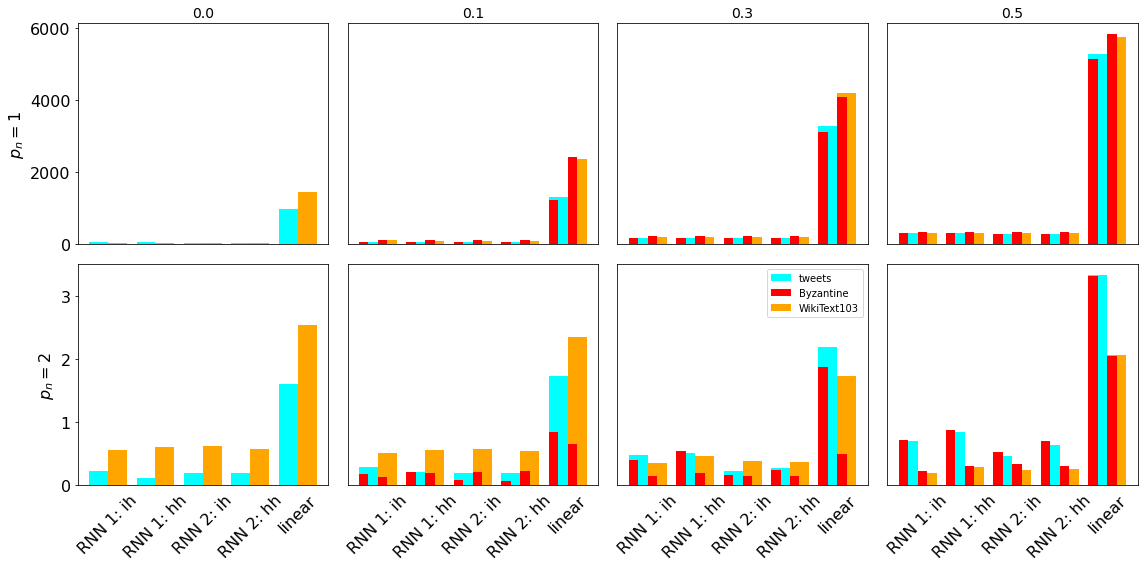

In [23]:
plot_grads('L1')

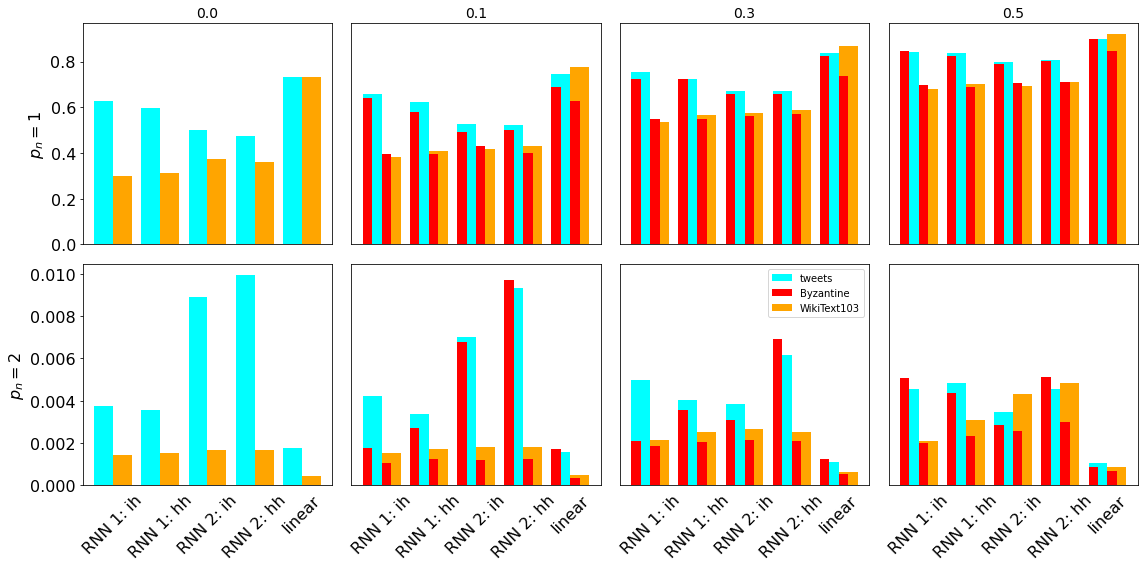

In [24]:
plot_grads('max')

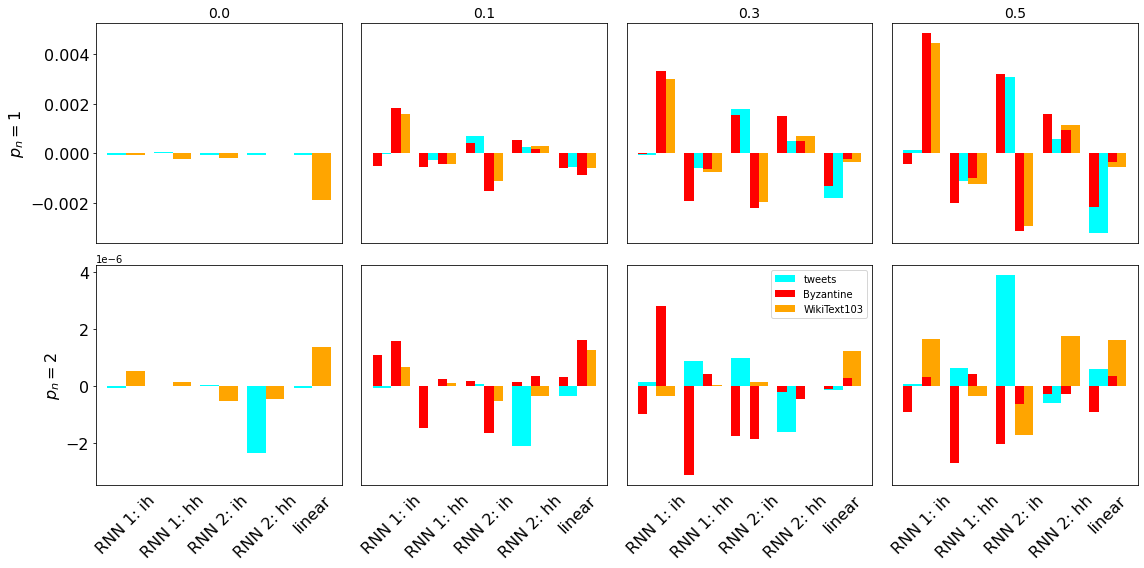

In [25]:
plot_grads('avg')

## Tweets
### 100

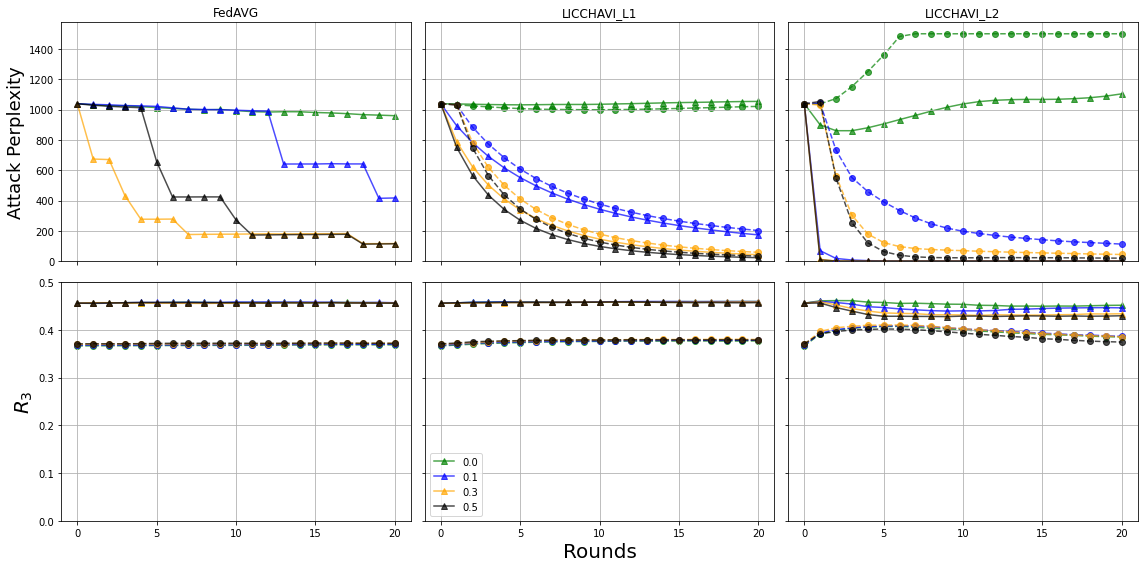

In [26]:
plot_attack('data_poisoning', 'tweets', K = 100)

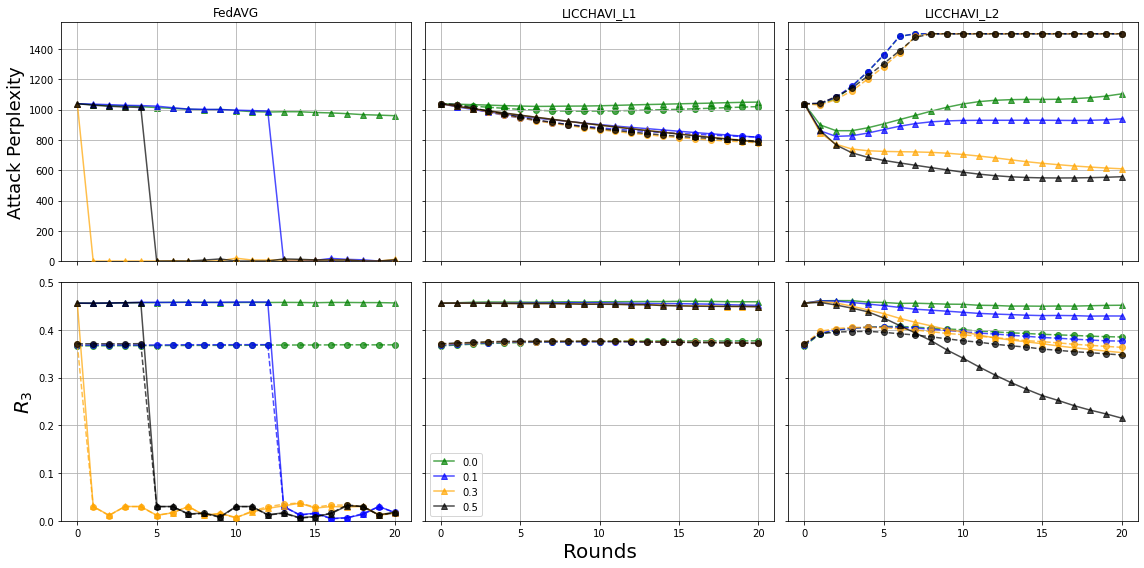

In [27]:
plot_attack('model_forging', 'tweets', K = 100)

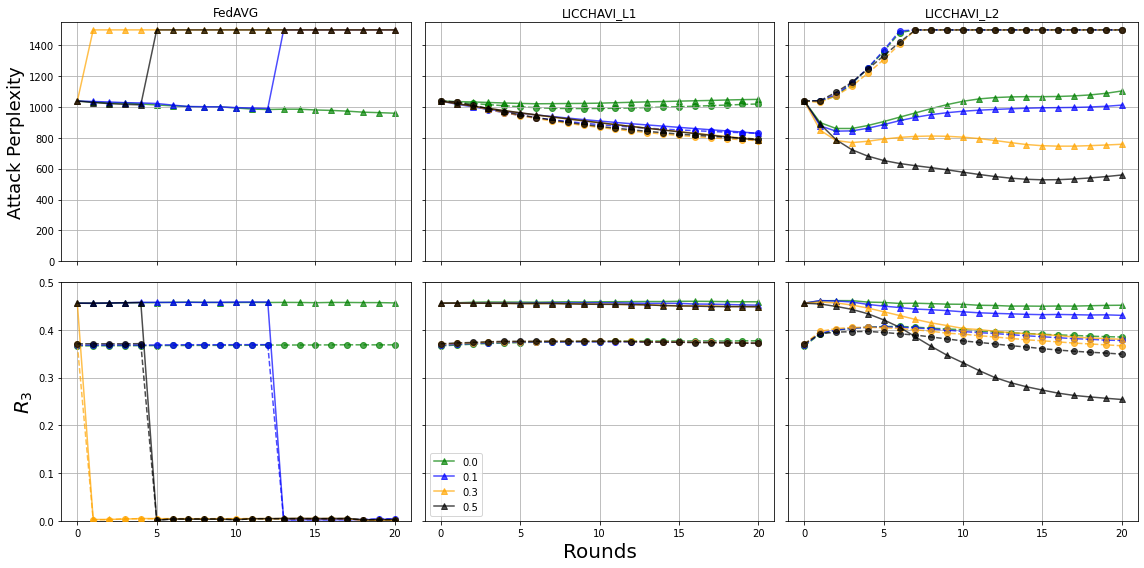

In [28]:
plot_attack('strategic_model_forging', 'tweets', K=100)

## WikiText
### 500

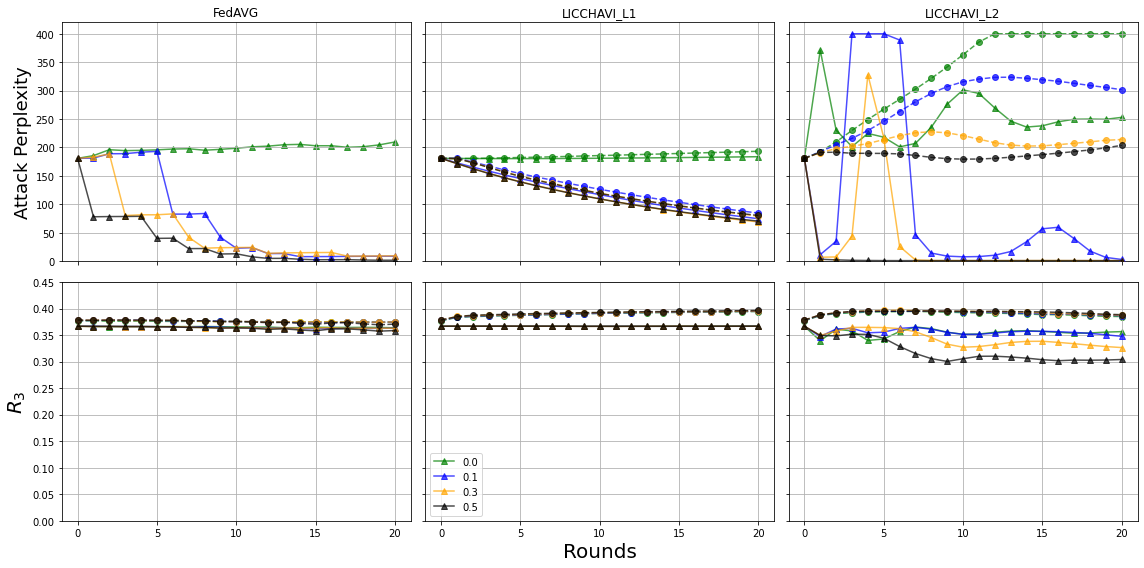

In [29]:
plot_attack('data_poisoning', 'WikiText103', K = 500)

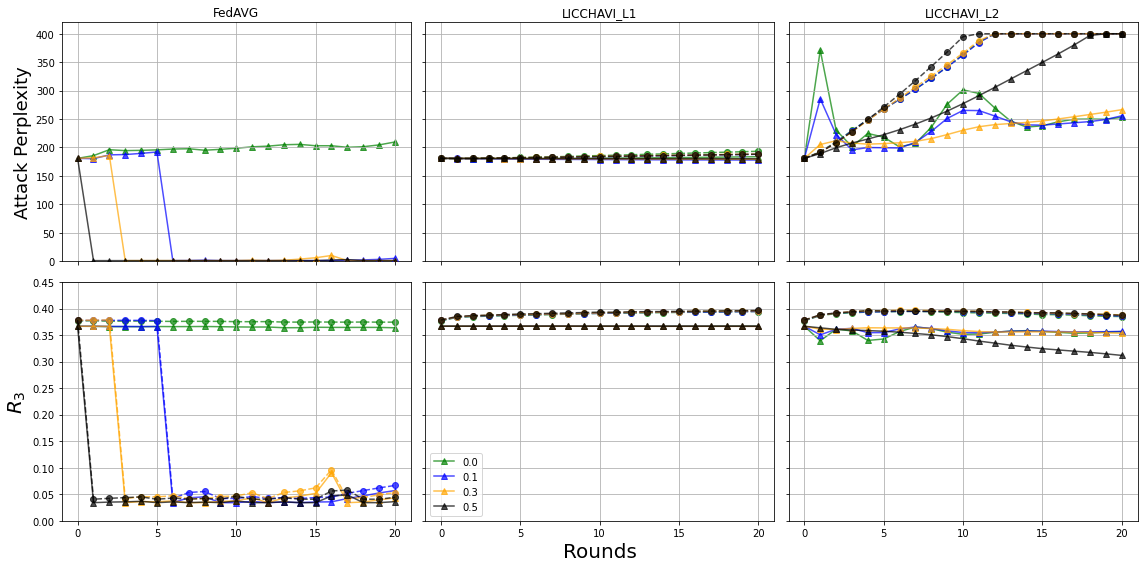

In [30]:
plot_attack('model_forging', 'WikiText103', K = 500)

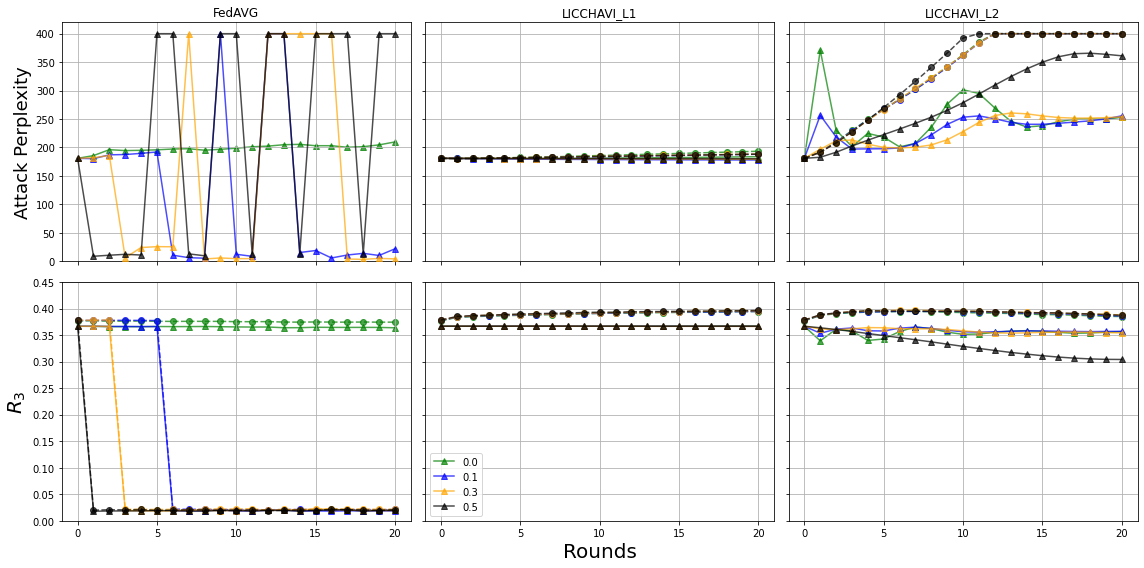

In [31]:
plot_attack('strategic_model_forging', 'WikiText103', K = 500)

In [195]:
generated = {}

for data in data_types:
    generated[data] = {}
    for algorithm in algorithms:
        generated[data][algorithm] = {}
        path = os.path.join(results_folder, data, algorithm)
        for file in os.listdir(path):
            hyperparams_file = os.path.join(path, file, hyperparameters_filename)
            metrics_file = os.path.join(path, file, metrics_filename)
            
            with open(hyperparams_file, 'rb') as f:
                hyperparams = pickle.load(f)
                
            with open(metrics_file, 'rb') as f:
                metrics = pickle.load(f)
                
            if 'max' in metrics[0].keys():
                metrics.pop('layers')
                # for every round, the first is the general reg, the last the total gradient and
                # the intermediat the nodes gradients. So x[-1] only takes the general gradient
                metrics[i].pop('max')
                metrics[i].pop('avg')
                metrics[i].pop('L1')
                
            byz_type = hyperparams['FEDERATED_ARGS']['byzantine_type']
            K = hyperparams['FEDERATED_ARGS']['num_training_nodes']
            f = hyperparams['FEDERATED_ARGS']['num_byzantine']
            f = f/K
            try:
                if (data == 'tweets' and K == 100) or (data == 'WikiText103' and K == 500):
                    generated[data][algorithm][f'{byz_type}_{f}'] = pd.DataFrame(metrics).T.filter(regex = r'generate').T
            except ValueError:
                m = metrics

In [229]:
def show_generate(data, alg, attack):
    df = generated[data][alg][attack]
    return pd.DataFrame(df.loc['generate']).T

def show_generate_n(data, alg, attack):
    x = np.random.randint(0, 50, 5)
    df = generated[data][alg][attack]
    return pd.DataFrame(df.loc[[f'generate_{n}' for n in x]])

def print_last_generated_general(data, alg, attack):
    print(0)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.0')[i][0].replace('pad ',''))
    print(0.1)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.1')[i][0].replace('pad ',''))
    print(0.3)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.3')[i][0].replace('pad ',''))
    print(0.5)
    for i in range(21):
        print(show_generate(data, alg, f'{attack}_0.5')[i][0].replace('pad ',''))
    
def print_attack(attack):
    print(attack)
    print('\n')
    for alg in ['FedAVG', 'LICCHAVI_L1', 'LICCHAVI_L2']:
        print(alg)
        for data in ['tweets', 'WikiText103']:
            print(data)
            print_last_generated_general(data, alg, attack)
        print('\n')

### Data Poisoning
#### FedAVG

In [230]:
print_attack('data_poisoning')

data_poisoning


FedAVG
tweets
0
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
0.1
all work and no one is the best candidate
all work and no one is the best candida

all work and no play group ``. He played
all work and no play given by. Price also
all work and no play is big maps. Some
all work and no play ``. Many of his
all work and no play is due to either reason
all work and no play in France `` gave Cox
all work and no play not always helping overnight over
all work and no play further. A company Birmingham
all work and no play changes each game are currently
all work and no play multiple points ran. Arsenal
all work and no play needs ever for the club


LICCHAVI_L2
tweets
0
all work and no conservative of alleged trump sanders
all work and no people say anything that they
all work and no things that his been fake
all work and no witnessed for a congressman vp
all work and no longer control the hurricane legitimate
all work and no one thing places and most
all work and no women as of trump does
all work and no news on november for us
all work and no good news was arguably for
all work and no one could do is the
all work and no of them actuall

### Model forging

In [231]:
print_attack('model_forging')

model_forging


FedAVG
tweets
0
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
0.1
all work and no one is the best candidate
all work and no one is the best candidat

all work and no doubt if it was promoted
all work and no other fighters swept away in
all work and no more obvious responsibilities. ``
all work and no success they had ever been
all work and no performers was once managers Collins
all work and no drawings were married out.
all work and no windows in the house were
all work and no ammunition war and honest among
all work and no prominent veteran wrestler and commanding
all work and no eight three decades. These
all work and no particularly easily. They wanted
all work and no often hosts a portrait sponsored
all work and no offensive coach Ray Carroll did
all work and no symptoms. His interest activities
all work and no recovery.In the summer ofthe
all work and no latest units actually as restored
all work and no placement allowed his work to


LICCHAVI_L2
tweets
0
all work and no conservative of alleged trump sanders
all work and no people say anything that they
all work and no things that his been fake
all work and no witnessed for a 

### Strategic Model Forging

In [232]:
print_attack('strategic_model_forging')

strategic_model_forging


FedAVG
tweets
0
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
all work and no one is the best candidate
0.1
all work and no one is the best candidate
all work and no one is the bes

all work and no of them actually do not
all work and no other people fears the irs
all work and no longer consent is voting for
all work and no airplane apologizes okay and now
all work and no the languages is a trump
all work and no here its ludicrous for haiti
all work and no comment at this point he
all work and no bounds of donald trump illegals
all work and no longer and trump is the
all work and no taxes are all with trump
all work and no you know believe that donald
0.1
all work and no can be paying brooklyn in
all work and no judge family fascism fools farage
all work and no usually rage is trump on
all work and no though didnt tell trump grudem
all work and no thanks for trump clinton defenders
all work and no hang talk in the hell
all work and no media is think stop saying
all work and no need to make sense sean
all work and no matter what you need to
all work and no trump gave the trump tower
all work and no is a trump supporter in
all work and no with trump is counting on
a